In [1]:
import numpy as np
from skimage.io import imread, imsave
from skimage.exposure import rescale_intensity
from skimage.draw import disk, circle_perimeter
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
import os
import cv2 as cv

%matplotlib inline

In [2]:
ROOT = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT, 'Data')

image_dir = os.path.join(DATA_DIR, 'raw')
mask_dir = os.path.join(DATA_DIR, 'mask')

# Cell segmentation using a Level Set method 

## Introduction to Level Set method

Level Set method models the changes in the shapes of an object over time by tracking the evolution of a zero-level function. A zero-level function is the intersection of a high-dimensional surface $\psi$ and the plane at height 0. 
Through initializing an initial curve, it is evolves the curve until it stops at an object's boundary.

![curve evolution](../Data/imgs/levelset-square.png)

When the suface evolves, cups can appear, they can later narrow, or disappear. The zero level set shows contours splitting and merging as illustrated in the figure below:

![n-50](../Data/imgs/levelset-n-50.png)  ![n-50](../Data/imgs/levelset-n-52.png) 
![n-90](../Data/imgs/levelset-n-90.png)  ![n-120](../Data/imgs/levelset-n-120.png) 

## Level Set method implementation

1.  We start by initializing a distance image from a binary image that contains the shape of an
initial curve. Each pixel of the distance image contains a value of 𝑑 that equals the distance from the
pixel to the boundary of a shape: 𝑑 < 0 inside the boundary and 𝑑 > 0 outside the boundary.

In [3]:
# Initialize a guesss of the contour
def initialize(img):
    '''
    Distance transforming image into a family of level sets psi = +/-d
    The psi = 0 level always yields the moving front of a shape, aka the curve.
    '''
    img = np.clip(img, 0, 255)
    img_invert = 255 - img # this step will change boundaries to 0
    img = img.astype('uint8')
    img_invert = img_invert.astype('uint8')
    if len(img.shape) > 2:
        # conver to single-channgle gray-scale image
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
        img_invert = cv.cvtColor(img_invert, cv.COLOR_BGR2GRAY)
    # distance transform the image with a 3 x 3 kernel. 
    dist_img = cv.distanceTransform(img, cv.DIST_L2, 3)
    # img_invert[dist_img==dist_img.max()] = 255 # (omitted because we only need distance to the boundary) need to restore the boundaries
    dist_img_invert = cv.distanceTransform(img_invert, cv.DIST_L2, 3)
    psi = dist_img + dist_img_invert 
    dist_img = -1 * dist_img # the distances inside the boundaries are negative
    psi = dist_img + dist_img_invert # now the boundaries are fixed and zero
    psi = cv.GaussianBlur(psi, (3,3), sigmaX=1, borderType=cv.BORDER_DEFAULT)
    psi = np.longdouble(psi)
    return psi

2. we modeled the evolution of 𝜓 with 𝜕𝜓 (𝑥 (𝑡 ),𝑡 )
𝜕𝑡 , where 𝑡 is time and 𝑥 (𝑡) is any point on the
surface at time 𝑡. We know there is no change along a curve. Therefore by the chain rule, we have;

$$
\begin{align*}
\frac{\partial \psi(x(t),t)}{\partial t} &= 0\\
    \frac{\partial \psi}{\partial (x(t))} \frac{\partial (x(t))}{\partial t}  + \frac{\partial \psi}{t}\frac{t}{\partial t} &= 0\\
    \nabla \psi x_t + \psi_t &= 0\\
\end{align*}
$$

where $\frac{\partial \psi}{\partial (x(t))} = \nabla \psi$, the gradient of at $x(t)$. $x_t$ is the speed term which we factored $x_t = F(x(t))\overrightarrow n$ where $F$ is the force normal to $\nabla \psi$ and $\overrightarrow n = \frac{\nabla \psi}{|\nabla \psi|}$. Then we substitute $x_t = F(x(t))\overrightarrow n$ into the above equation to get;

$$
\begin{align*}
    \nabla \psi F(x(t))\overrightarrow n + \psi_t &= 0\\
    \nabla \psi F(x(t)) \frac{\nabla \psi}{|\nabla \psi|} + \psi_t &= 0 \\
    F(x(t))|\nabla \psi| + \psi_t &= 0 \\
\end{align*}
$$

This is the motion of $\psi$. Now it is possible to evolve the initial curve at time $t=0$, $\psi(x,y,t=0)$ to get a curve at time $t=t'$, $\psi(x,y,t=t')$.

We can get the curvature $K$ from $\psi$;

$$
\begin{align*}
    K &= \nabla \cdot \frac{\nabla \psi}{|\nabla \psi|} \\
      &= -\frac{\psi_{xx}\psi_y^2 - 2\psi_y\psi_x\psi_{xy}+\psi_{yy}\psi_x^2}{(\psi_x^2 + \psi_y^2)^{3/2}}\\
\end{align*}
$$

In [4]:
def pad(a):
    '''
    Pad the edge of an array a
    '''
    if a.shape[0] < 1 or a.shape[1] < 1:
        print('Image has invalid shape: expected sizes of dimensions to be greater than 1.')
    a = np.hstack((a[:,0][:, np.newaxis], a))
    a = np.hstack((a, a[:,a.shape[1]-1][:, np.newaxis]))
    a = np.vstack((a[0,:][np.newaxis, :], a))
    a = np.vstack((a, a[a.shape[0]-1,:][np.newaxis, :]))
    return a

def central_difference(psi):
    '''
    Compute central differences along x-axis, y-axis, and between x,y-axes
    '''
    # expanding psi to prevent shrinking in size after taking differences
    psi = pad(psi)
    m, n = psi.shape
    # print(m,n)
    dx = 0.5 * (psi[1:m-1, 2:n]-psi[1:m-1, 0:n-2])
    dy = 0.5 * (psi[2:m, 1:n-1]-psi[0:m-2, 1:n-1])
    dxx = (psi[1:m-1, 2:n] - psi[1:m-1, 1:n-1]) - (psi[1:m-1, 1:n-1] - psi[1:m-1, 0:n-2])
    dyy = (psi[2:m, 1:n-1] - psi[1:m-1, 1:n-1]) - (psi[1:m-1, 1:n-1] - psi[0:m-2, 1:n-1])
    dxy = 0.25 * ((psi[2:m, 2:n] - psi[2:m, 0:n-2]) - (psi[0:m-2, 2:n] - psi[0:m-2, 0:n-2]))
    return dx, dy, dxx, dyy, dxy

def get_K(psi):
    dx, dy, dxx, dyy, dxy = central_difference(psi)
    eps = np.finfo('float').eps
    K = (dxx*dy**2 - 2*dy*dx*dxy + dyy*dx**2) / (np.power(dx**2 + dy**2, 1.5) + eps)
    return K

3. Finally, we need to stop the movement of the front of the surface $\psi$ at the edges of an object. To do so, we formulate $F$ to be the inverse of the image gradient, i.e.; $$F=\frac{1}{1 + |\nabla (G_{\sigma} * I)|^2}$$


In [5]:
def get_stopping_term(img, c=1):
    '''
    c contronls how penalizing the edges should be
    '''
    # print(img.shape)
    if len(img.shape) > 2:
        img = img.astype('uint8')
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = pad(img)
    m,n = img.shape
    dx = 0.5 * (img[2:m, 1:n-1]-img[0:m-2, 1:n-1])
    dy = 0.5 * (img[1:m-1, 2:n]-img[1:m-1, 0:n-2])
    grad_mag = np.sqrt(dx**2 + dy**2)
    # return np.exp(-1*(grad_mag)**2 / (2*c**2)) # return the gaussian of the gradient magnitude
    return 1. / (1. + grad_mag**2)

To update the surface $\psi$ with our new $F$, we update $\psi$ by adding a $d\psi$ which includes three parts. The first part is to move the front in the direction of $\overrightarrow n$. The second part is to penalize high curvature K to make the front smooth. The last part is to add the gradient of the inverse of the image gradient, i.e. $\nabla F, $. This last step is to make the front movement slow down near the edge. The first and second parts are also multiplied by the stopping term $g$. Altogether $d\psi$ is the following:

$$
\begin{align*}
    d \psi = \underbrace{F|\nabla I|}_{\text{moving front}} + \underbrace{FK|\nabla I|}_{\text{smoothing}} + \underbrace{\langle\nabla F \cdot \nabla I\rangle}_{\text{slow down near edges}}
\end{align*}
$$

Therefore, at each iteration $\psi$ is updated with;

$$
\begin{align*}
    \psi(x,y,t+\Delta t) &= \psi(x,y,t) + d\psi \\
                         &= \psi(x,y,t) + \Delta t(F|\nabla I| + FK|\nabla I| + \langle\nabla F \cdot \nabla I\rangle)
\end{align*}
$$

In [6]:
def curve_evolution(contour, img, dt=0.1, velocity=0.5, max_iter=1000):
    '''
    Evolve the curve based on the magitude the image gradient, curvature and gradient of image
    '''
    psi = initialize(contour)
    # Adjust force according to the gradient of the image
    F = get_stopping_term(img)
    fx, fy, _, _, _ = central_difference(F) # take the derivative of stopping term to make curve evolution slow down near curves (or boundaries)
    for i in range(max_iter):
        K = get_K(psi)
        dx, dy, _, _, _ = central_difference(psi)
        grad_mag = np.sqrt(dx**2 + dy**2)
        expansion = F * grad_mag
        smoothing = F * K * grad_mag
        attachment = fx*dx + fy*dy # slow down in the direction of perpenticular to the surface psi
        psi[:] = psi[:] + (dt * expansion + dt * smoothing + dt * attachment)
    return psi

## Test on binary images

In [7]:
def draw_curve(psi, axis, colors='red', levels=[0]):
    '''
    Draw curve U on an image. By default, it is drawn in the red channel
    '''
    # curve at zero-crossing
    # draw levels with equal spacings
    # find the curve that cross zero level
    X = np.arange(0, psi.shape[1])
    Y = np.arange(0, psi.shape[0])
    xs, ys = np.meshgrid(X, Y, sparse=True)
    Z = psi[ys, xs]
    return axis.contour(X, Y, Z, levels=levels, colors=colors)

def run_experiment(max_iters, contour_layer, img):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 50))
  
    for i in range(3):
        # initalize psi
        psi = initialize(contour_layer)
        # evolve the contour with psi
        psi = curve_evolution(contour_layer, img, dt=0.2, max_iter=max_iters[i])

        axs[i].imshow(img, cmap='gray')
        draw_curve(psi, axis=axs[i])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        axs[i].set_xticks([])
        axs[i].title.set_text("iteration = "+str(max_iters[i]))
        axs[i].set_yticks([])


Initialize a big curve and let it evolve to boundaries of objects

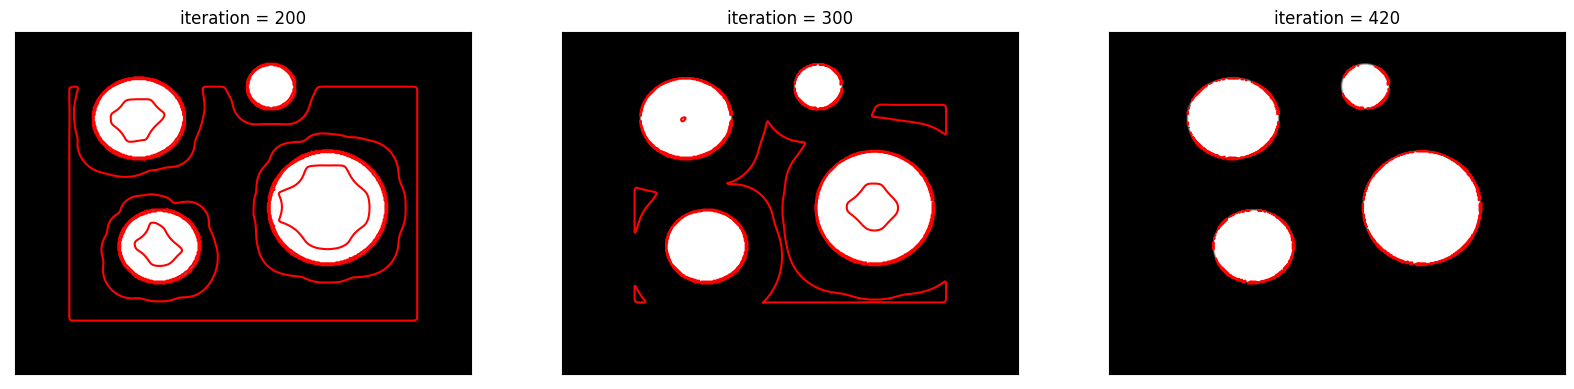

In [8]:
from skimage.draw import rectangle
# read in the test image 3
img = imread(os.path.join(DATA_DIR, "example", "test3.png"))
img = cv.GaussianBlur(img, (3,3), sigmaX=1, borderType=cv.BORDER_DEFAULT)
contour_layer = np.zeros_like(img)
# initialize a large circle
start = (20,20)
end = (contour_layer.shape[0]-20, contour_layer.shape[1]-20) 
rr, cc = rectangle(start=start, end=end)
contour_layer[rr, cc, :] = [255, 255, 255]

max_iters = [200, 300, 420]
run_experiment(max_iters, contour_layer, img)

## Test on cell image
Test on the easy one 

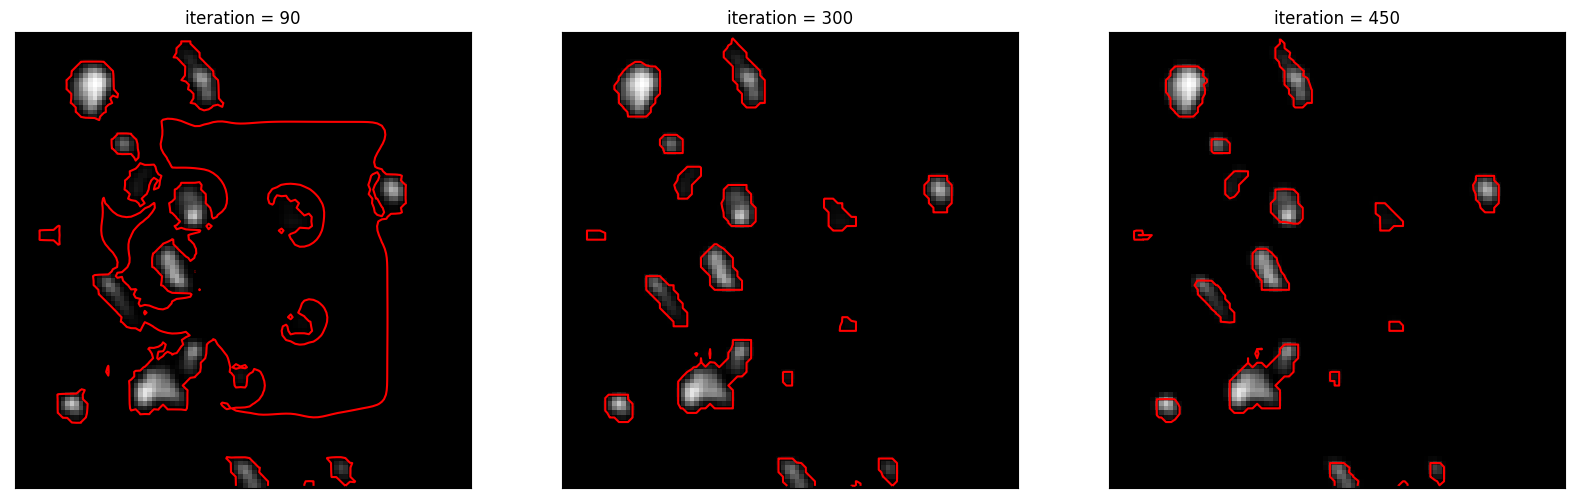

In [10]:
# read in cell image

img = imread('../Data/raw/test_easy_img.png')
# img = np.clip(img, 0, 255)
img = cv.GaussianBlur(img, (3,3), sigmaX=1, borderType=cv.BORDER_DEFAULT)

# initialize a large rectangle
contour_layer = np.zeros_like(img)
start = (2,2)
end = (contour_layer.shape[0]-2, contour_layer.shape[1]-2) 
rr, cc = rectangle(start=start, end=end)
contour_layer[rr, cc] = 255


max_iters = [90, 300, 450]
run_experiment(max_iters, contour_layer, img)

Test on the hard one

Not able to separate cells in densely packed regions

In [1]:
# read in cell image

img = imread('../Data/raw/cropped_cell_im.png')
# img = np.clip(img, 0, 255)
img = cv.GaussianBlur(img, (3,3), sigmaX=1, borderType=cv.BORDER_DEFAULT)
# plt.imshow(img, cmap='gray')
# initialize a large rectangle
contour_layer = np.zeros_like(img)
start = (2,2)
end = (contour_layer.shape[0]-2, contour_layer.shape[1]-2) 
rr, cc = rectangle(start=start, end=end)
contour_layer[rr, cc] = 255

max_iters = [300, 500, 700]
run_experiment(max_iters, contour_layer, img)

NameError: name 'imread' is not defined